In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import Counter
from PIL import Image
from skimage import io
import cv2 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim
import torchvision.datasets
import torchvision.transforms as T 
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
from matplotlib.ticker import MaxNLocator
from torchvision.models import alexnet
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import os
import torch, torchvision
import shutil

## Function to get features/Activation values of the model from last layer before classifer

In [2]:
normalize=T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
"""
Adapted Activation Clustering as a backdoor input detector.
For comparison and reference only.
"""

#for alexnet function 
def get_pre_fc_layer_activations(model, input_tensor, device):
    model.eval()
    input_tensor = normalize(input_tensor)  # Ensure this normalization matches your preprocessing
    with torch.no_grad():
        x = input_tensor.to(device)
        
        # Pass through the feature extractor part of AlexNet
        x = model.features(x)  # This replaces the explicit calls to conv, bn, relu, etc.
        
#         # Apply the avgpool layer
        x = model.avgpool(x)
        
        # Flatten the output for further processing, resulting in shape [N, C]
        activations = torch.flatten(x, start_dim=1)
        return activations

## Classes for the dataset

In [3]:
class GTSRBBackdooredDataset(Dataset):
    def __init__(self, directory_path, transform=None, num_images_to_test=None):
        self.directory_path = directory_path
        self.transform = transform
        self.all_filenames = os.listdir(directory_path)

        if num_images_to_test:
            self.all_filenames = self.all_filenames[:num_images_to_test]

        self.labels = [14] * len(self.all_filenames)  # Example fixed label for all images

    def __len__(self):
        return len(self.all_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.directory_path, self.all_filenames[idx])
        image = Image.open(image_path)
        image = image.resize([224, 224])  # Resize if necessary

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label
    
class GTSRBCleanDataset(Dataset):
    def __init__(self, directory_path, csv_path, transform=None, num_images_to_test=None):
        self.directory_path = directory_path
        self.transform = transform

        # Load ground truth from CSV
        data = pd.read_csv(csv_path, delimiter=',')
        self.filenames = data['Path'].apply(os.path.basename).tolist()
        self.labels = data['ClassId'].tolist()
        self.truth_dict = dict(zip(self.filenames, self.labels))

        # Filter filenames if num_images_to_test is set
        if num_images_to_test:
            self.filenames = self.filenames[:num_images_to_test]
            self.labels = self.labels[:num_images_to_test]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image_name = self.filenames[idx]
        image_path = os.path.join(self.directory_path, image_name)
        image = Image.open(image_path)
        image = image.resize([224, 224])  # Resize if necessary

        if self.transform:
            image = self.transform(image)

        label = self.truth_dict[image_name]
        return image, label
    
    
class TSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None, exclude_indices=None):
        self.root_dir = root_dir
        self.transform = transform
        self.exclude_indices = set(exclude_indices) if exclude_indices is not None else set()
        self.data = []
        self.class_counts = Counter()

        temp_data = []

        for class_id in sorted(os.listdir(root_dir), key=lambda x: int(x)):
            class_dir = os.path.join(root_dir, class_id)
            if os.path.isdir(class_dir):
                for filename in sorted(os.listdir(class_dir)):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        temp_data.append({
                            'path': os.path.join(class_dir, filename),
                            'class_id': int(class_id)
                        })

        # # Debugging prints
        # print(f"Total data before exclusion: {len(temp_data)}")
        # print(f"Excluding indices: {self.exclude_indices}")

        self.data = [data for i, data in enumerate(temp_data) if i not in self.exclude_indices]

        # Recalculate class counts after exclusion
        for item in self.data:
            self.class_counts[item['class_id']] += 1

        # More debugging prints
        # print(f"Total data after exclusion: {len(self.data)}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]['path']
        image = Image.open(image_path)
        y_class = torch.tensor(self.data[index]['class_id'])
        
        if self.transform:
            image = self.transform(image)

        return image, y_class,index
    
    def get_image_path_by_index(self, index):
        """Get the file path for the image at the specified index."""
        return self.data[index]['path']

    def get_class_label_by_index(self, index):
        """Retrieve the class label for a given dataset index."""
        return self.data[index]['class_id']





## Helping functions for visualization and verifications

In [4]:
import matplotlib.pyplot as plt

def visualize_images(images, cols=5):
    """Visualize a list of images."""
    n_images = len(images)
    rows = n_images // cols + int(n_images % cols != 0)
    fig = plt.figure(figsize=(20, 4 * rows))
    for i, image in enumerate(images):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(image.permute(1, 2, 0))  # Convert from PyTorch format to matplotlib format
        ax.axis('off')
    plt.show()


def collect_images_by_class(data_loader, class_id, max_images=10):
    collected_images = []
    for images, labels in data_loader:
        for image, label in zip(images, labels):
            if label.item() == class_id and len(collected_images) < max_images:
                collected_images.append(image)
    return collected_images

def count_images_of_specific_class(dataloader, class_id):
    total_images = 0
    for _, labels,_ in dataloader:
        # Count how many times class_id appears in labels
        total_images += torch.sum(labels == class_id).item()
    return total_images


def copy_non_suspicious_images(dataset, suspicious_indices, new_root_dir):
    if not os.path.exists(new_root_dir):
        os.makedirs(new_root_dir)
    
    for index in range(len(dataset)):
        if index not in suspicious_indices:
            continue  # Skip copying this suspicious image
        
        image_path = dataset.get_image_path_by_index(index)
        # Construct the new path under new_root_dir maintaining the original structure
        new_path = image_path.replace(dataset.root_dir, new_root_dir)
        # Create directories if they do not exist
        os.makedirs(os.path.dirname(new_path), exist_ok=True)
        # Copy the file
        shutil.copy2(image_path, new_path)
        print(f"Copied {image_path} to {new_path}")
        
def copy_suspicious_images(dataset, suspicious_indices, new_root_dir):
    if not os.path.exists(new_root_dir):
        os.makedirs(new_root_dir)
    
    for index in suspicious_indices:
        image_path = dataset.get_image_path_by_index(index)
        # Construct the new path under new_root_dir maintaining the original structure
        new_path = image_path.replace(dataset.root_dir, new_root_dir)
        # Create directories if they do not exist
        os.makedirs(os.path.dirname(new_path), exist_ok=True)
        # Copy the file
        shutil.copy2(image_path, new_path)
        print(f"Copied {image_path} to {new_path}")

def verify_suspicious_indices(dataset, suspicious_indices, expected_class):
    verified_indices = []
#     print("starting verification process")
    for idx in suspicious_indices:
        actual_class = dataset.get_class_label_by_index(idx)
#         print(f"image id:{idx}")
        if actual_class == expected_class:
            verified_indices.append(idx)
        else:
            print(f"Index {idx} does not belong to expected class {expected_class}, found in class {actual_class}.")
#     print("done with verification process")
    return verified_indices


def visualize_clusters(projected_feats, labels, largest_cluster_center, title='KMeans Clustering'):
    # Assuming projected_feats is 2D or has been reduced to 2 principal components
    plt.figure(figsize=(8, 6))

    # Step 2: Identify the Largest Cluster
    cluster_sizes = np.bincount(labels)
    #clean label as the largest cluster
    clean_label = np.argmax(cluster_sizes)

    poisonous_label = 1 - clean_label  # The other label is considered 'poisonous'
    
    # Plot each cluster using different colors and labels
    plt.scatter(projected_feats[labels == clean_label, 0], projected_feats[labels == clean_label, 1], 
                c='blue', label='Clean', marker='o')
    plt.scatter(projected_feats[labels == poisonous_label, 0], projected_feats[labels == poisonous_label, 1], 
                c='red', label='Poisonous', marker='x')
    
    # Plot the center of the largest cluster
    plt.scatter(largest_cluster_center[0], largest_cluster_center[1], 
                c='gold', label='Largest Cluster Center', marker='*', s=200)  # s is the size of the marker
    
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()  # Display the legend to differentiate clean, poisonous, and the center
    plt.show()

# def visualize_clusters(projected_feats, kmeans_labels, n_clusters, title='Cluster Visualization'):
#     """
#     Visualizes n clusters using matplotlib.

#     Parameters:
#     - projected_feats: 2D numpy array with the coordinates of the points after dimensionality reduction.
#     - kmeans_labels: 1D numpy array with the cluster labels for each point.
#     - n_clusters: Number of clusters to visualize.
#     - title: Title of the plot.
#     """
#     plt.figure(figsize=(8, 6))
#     colors = plt.cm.get_cmap('tab20', n_clusters)

#     for i in range(n_clusters):
#         plt.scatter(projected_feats[kmeans_labels == i, 0], projected_feats[kmeans_labels == i, 1], 
#                     color=colors(i), label=f'Cluster {i}')
    
#     plt.title(title)
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     plt.legend()
#     plt.show()






## Activation Clustering Cleansing

In [5]:
#getting features/activations from last layer based on image inputs
def get_features_training(data_loader, model, num_classes, device):
    model.eval()  # Set the model to evaluation mode
    class_indices = [[] for _ in range(num_classes)]  # Initialize class indices
    feats = []  # Initialize the list for storing features
    local_to_global_index_map = {} 

    with torch.no_grad():  # Disable gradient computation
        sid = 0
        for i, (data, target,indices) in enumerate(tqdm(data_loader)):
            data, target = data.to(device), target.to(device)  # Move data to the specified device
            
            extracted_feats = get_pre_fc_layer_activations(model, data, device)  # Extract features
            this_batch_size = len(target)
            # print("batch: ",this_batch_size)
            for bid in range(this_batch_size):
                feats.append(extracted_feats[bid])  # Append extracted features
                b_target = target[bid].item()  # Get the class/target of the sample

                # Append the global dataset index of the sample
                global_index = indices[bid].item()
                local_to_global_index_map[sid+bid] = global_index 

            
                class_indices[b_target].append(sid + bid)  # Append the index of the sample
                # if b_target==14:
                #     print(f"Class: {b_target} || Map Index {sid + bid} ||Dataset Index: {indices[bid].item()} ||path: {data_loader.dataset.get_image_path_by_index(indices[bid].item())}")
            sid += this_batch_size  # Update the sample ID offset

    return feats, class_indices,local_to_global_index_map


#this is the original version of this function from their paper 
def cleanser(inspection_split_loader, model, num_classes, device,verifier, clusters=2):
    """
        adapted from : https://github.com/hsouri/Sleeper-Agent/blob/master/forest/filtering_defenses.py
    """


    suspicious_indices = []

    feats, class_indices,local_to_global_index_map = get_features_training(inspection_split_loader, model, num_classes,device)

    myscore=[]
    max_score=0
    for target_class in range(num_classes):

        # print('class - %d' % target_class)

        if len(class_indices[target_class]) <= 1: continue # no need to perform clustering...

        temp_feats = [feats[temp_idx].unsqueeze(dim=0) for temp_idx in class_indices[target_class]]
        temp_feats = torch.cat( temp_feats , dim=0)
        temp_feats = temp_feats - temp_feats.mean(dim=0)

        _, _, V = torch.svd(temp_feats, compute_uv=True, some=False)

        axes = V[:, :10]
        projected_feats = torch.matmul(temp_feats, axes)
        projected_feats = projected_feats.cpu().numpy()

        # print("Shape of projected features: ",projected_feats.shape)

        # print('start k-means')
        kmeans = KMeans(n_clusters=clusters,init='k-means++').fit(projected_feats)
        # print('end k-means')

        # by default, take the large cluster as the clean cluster (since all inference-time backdoor inputs are in the target class)
        if kmeans.labels_.sum() >= len(kmeans.labels_) / 2.:
            clean_label = 1
        else:
            clean_label = 0
 
        largest_cluster_center = kmeans.cluster_centers_[clean_label]
        # print("clean label is: ",clean_label)

        outliers_local_indices = []
        for (bool, idx) in zip((kmeans.labels_ != clean_label).tolist(), list(range(len(kmeans.labels_)))):
            if bool:
                outliers_local_indices.append(class_indices[target_class][idx])
        
          # Map local class-specific indices to global indices in the dataset
        outliers_global_indices = [local_to_global_index_map[local_idx] for local_idx in outliers_local_indices]

        score = silhouette_score(projected_feats, kmeans.labels_)
        # print('[class-%d] silhouette_score = %f || ratio of %f ' % (target_class, score,len(outliers_global_indices)/len(kmeans.labels_) ))
        # if score > threshold:# and len(outliers) < len(kmeans.labels_) * 0.35:
        myscore.append(score)

         # if one of the two clusters is abnormally small, then we have suspicious indices 
        # if len(outliers_global_indices) < len(kmeans.labels_) * 0.40:
        #     #only record the score if we have highest silhoutte score
        #     if max_score<score: 
        #         visualize_clusters(projected_feats, kmeans.labels_,largest_cluster_center, title=f'Class {target_class} Clustering')

        #         suspicious_indices = outliers_global_indices.copy()
        #         max_score=score  
        if score>0.3: 
            # visualize_clusters(projected_feats, kmeans.labels_,largest_cluster_center, title=f'Class {target_class} Clustering')

            suspicious_indices = outliers_global_indices.copy()
            # max_score=score 
    most_suspicious_class=np.array(myscore).argmax()
    print("The poisoned class is: ",most_suspicious_class)
    return most_suspicious_class,suspicious_indices



In [6]:
#getting features/activations from last layer based on image inputs
def get_features_training(data_loader, model, num_classes, device):
    model.eval()  # Set the model to evaluation mode
    class_indices = [[] for _ in range(num_classes)]  # Initialize class indices
    feats = []  # Initialize the list for storing features
    local_to_global_index_map = {} 

    with torch.no_grad():  # Disable gradient computation
        sid = 0
        for i, (data, target,indices) in enumerate(tqdm(data_loader)):
            data, target = data.to(device), target.to(device)  # Move data to the specified device
            
            extracted_feats = get_pre_fc_layer_activations(model, data, device)  # Extract features
            this_batch_size = len(target)
            # print("batch: ",this_batch_size)
            for bid in range(this_batch_size):
                feats.append(extracted_feats[bid])  # Append extracted features
                b_target = target[bid].item()  # Get the class/target of the sample

                # Append the global dataset index of the sample
                global_index = indices[bid].item()
                local_to_global_index_map[sid+bid] = global_index 

            
                class_indices[b_target].append(sid + bid)  # Append the index of the sample
                # if b_target==14:
                #     print(f"Class: {b_target} || Map Index {sid + bid} ||Dataset Index: {indices[bid].item()} ||path: {data_loader.dataset.get_image_path_by_index(indices[bid].item())}")
            sid += this_batch_size  # Update the sample ID offset

    return feats, class_indices,local_to_global_index_map


#this is the original version of this function from their paper 
def cleanser(inspection_split_loader, model, num_classes, device,verifier, clusters=2):
    """
        adapted from : https://github.com/hsouri/Sleeper-Agent/blob/master/forest/filtering_defenses.py
    """


    suspicious_indices = []

    feats, class_indices,local_to_global_index_map = get_features_training(inspection_split_loader, model, num_classes,device)

    myscore=[]
    max_score=0
    for target_class in range(num_classes):

        # print('class - %d' % target_class)

        if len(class_indices[target_class]) <= 1: continue # no need to perform clustering...

        temp_feats = [feats[temp_idx].unsqueeze(dim=0) for temp_idx in class_indices[target_class]]
        temp_feats = torch.cat( temp_feats , dim=0)
        temp_feats = temp_feats - temp_feats.mean(dim=0)

        _, _, V = torch.svd(temp_feats, compute_uv=True, some=False)

        axes = V[:, :10]
        projected_feats = torch.matmul(temp_feats, axes)
        projected_feats = projected_feats.cpu().numpy()

        # print("Shape of projected features: ",projected_feats.shape)

        # print('start k-means')
        kmeans = KMeans(n_clusters=clusters,init='k-means++').fit(projected_feats)
        # print('end k-means')

        # by default, take the large cluster as the clean cluster (since all inference-time backdoor inputs are in the target class)
        if kmeans.labels_.sum() >= len(kmeans.labels_) / 2.:
            clean_label = 1
        else:
            clean_label = 0
 
        largest_cluster_center = kmeans.cluster_centers_[clean_label]
        # print("clean label is: ",clean_label)

        outliers_local_indices = []
        for (bool, idx) in zip((kmeans.labels_ != clean_label).tolist(), list(range(len(kmeans.labels_)))):
            if bool:
                outliers_local_indices.append(class_indices[target_class][idx])
        
          # Map local class-specific indices to global indices in the dataset
        outliers_global_indices = [local_to_global_index_map[local_idx] for local_idx in outliers_local_indices]

        score = silhouette_score(projected_feats, kmeans.labels_)
        # print('[class-%d] silhouette_score = %f || ratio of %f ' % (target_class, score,len(outliers_global_indices)/len(kmeans.labels_) ))
        # if score > threshold:# and len(outliers) < len(kmeans.labels_) * 0.35:
        myscore.append(score)

         # if one of the two clusters is abnormally small, then we have suspicious indices 
        # if len(outliers_global_indices) < len(kmeans.labels_) * 0.40:
        #     #only record the score if we have highest silhoutte score
        #     if max_score<score: 
        #         visualize_clusters(projected_feats, kmeans.labels_,largest_cluster_center, title=f'Class {target_class} Clustering')

        #         suspicious_indices = outliers_global_indices.copy()
        #         max_score=score  
        if score>0.3: 
            # visualize_clusters(projected_feats, kmeans.labels_,largest_cluster_center, title=f'Class {target_class} Clustering')

            suspicious_indices = outliers_global_indices.copy()
            # max_score=score 
    # most_suspicious_class=np.array(myscore).argmax()
    # meanv = np.array(myscore).mean()
    # myscore.pop(most_suspicious_class)
    # second_most_suspicious_class = np.array(myscore).argmax()
            
    most_suspicious_class=np.array(myscore).argmax()
    meanv = np.array(myscore).mean()
    larg = myscore.pop(most_suspicious_class)
    second_most_suspicious_class = np.array(myscore).argmax()

    # print("The poisoned class is: ", most_suspicious_class, larg, second_most_suspicious_class, myscore[second_most_suspicious_class], meanv)
    # return most_suspicious_class, (larg - myscore[second_most_suspicious_class])/meanv, suspicious_indices
    return most_suspicious_class, larg - myscore[second_most_suspicious_class], suspicious_indices



## Plotting accuracies

In [7]:
def plot_accuracy(train_loss, clean_val_loss,backdoored_val_loss ,train_acc, val_acc,val_backdoored_acc):
    # Convert the lists to numpy arrays for indexing
    train_loss = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
#     val_loss = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
    train_acc = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
    val_acc = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
    val_backdoored_acc = np.array([vb.cpu() if isinstance(vb, torch.Tensor) else vb for vb in val_backdoored_acc])
    epochs = len(train_loss) 

    plt.figure(figsize=(12, 4))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, 1+epochs), y=train_loss, label='Training Loss')
    sns.lineplot(x=range(1, 1+epochs), y=clean_val_loss, label='Clean Loss')
    sns.lineplot(x=range(1, 1+epochs), y=backdoored_val_loss, label='Backdoored Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, 1+epochs), y=train_acc, label='Training Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=val_acc, label='Clean Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=val_backdoored_acc, label='Backdoored Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()


## Predictign functions

In [8]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

def load_model(model_path, num_classes=43, device="cpu"):
    model = alexnet(weights=None, num_classes=43).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set to evaluation mode
    print("Loading Model-----------------Status: Done")
    return model

def process_image(image_path):
    # Load the image
    image = Image.open(image_path)

    # Define 5
    data_transforms = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Apply transformations
    image_tensor = data_transforms(image).unsqueeze(0)
    return image_tensor, image

def predict(image_path, model, device="cpu"):
    # No need to reload the model every time you predict. Use the passed model.
    # model = load_model(model_path, device=device)
    
    image_tensor, image = process_image(image_path)  # Assume process_image returns (tensor, image)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_class_index = torch.max(outputs, 1)

    return predicted_class_index.item(), image

def get_ground_truth_from_csv(csv_path):
    """Load the CSV file and return a dictionary with filenames as keys and labels as values."""
    data = pd.read_csv(csv_path, delimiter=',')  # Use the comma delimiter
    # Use os.path.basename() to extract just the image filename
    filenames = data['Path'].apply(os.path.basename).tolist()
    truth_dict = dict(zip(filenames, data['ClassId']))
    return truth_dict

def predict_on_clean_Dataset(directory_path, model_path, num_images_to_test=None, device="cpu"):
    model = load_model(model_path, device=device)
    
    class_names = pd.read_csv('/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/labels.csv')['Name'].tolist()
    
    ground_truth = get_ground_truth_from_csv('/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/Test.csv')
    filenames = os.listdir(directory_path)
#     random.shuffle(filenames)
    
    if num_images_to_test:
        filenames = filenames[:num_images_to_test]

    correct_count = 0
    total_count = 0
    print("Starting Prediction....")
    for filename in filenames:
        image_path = os.path.join(directory_path, filename)
        
        if image_path.lower().endswith('.ppm') or image_path.lower().endswith('.png'):
            predicted_class_index, image = predict(image_path, model, device)
            predicted_class_name = class_names[predicted_class_index]
            
            # Compare with ground truth
            true_class_index = ground_truth.get(filename, None)
            if true_class_index is not None:
                total_count += 1
                if predicted_class_index == true_class_index:
                    correct_count += 1
        
    print(f"Average Accuracy: {correct_count / total_count * 100:.2f}%")
    
def predict_on_backdoored_directory(directory_path, model_path, num_images_to_test=None, device="cpu"):
    model = load_model(model_path, device=device)
    
    # Assuming you have class names to interpret the outputs (you need to define this list)
    class_names = pd.read_csv('gtsrb-german-traffic-sign/labels.csv')['Name'].tolist()
    # List all files in the directory
    filenames = os.listdir(directory_path)
    random.shuffle(filenames)
    #count number of correct prediction
    correct_count=0
    #initialize the ground truth class id
    #for now, I am checking if the model can predict the backdoored stop sign which belong to class 14
    actual_class_index=14
    # Limit the number of files processed
    if num_images_to_test:
        filenames = filenames[:num_images_to_test]

    for filename in filenames:
        image_path = os.path.join(directory_path, filename)
        
        # Process only .png images (according to your error traceback)
        if image_path.lower().endswith('.png'):
            predicted_class_index, image = predict(image_path, model, device)

            predicted_class_name = class_names[predicted_class_index]
    
            if(predicted_class_index==actual_class_index):
                correct_count+=1

    print(f'Accuracy of backdoored Model images of class {class_names[14]} is :{correct_count / num_images_to_test * 100:.2f}%')


## Training function 

In [9]:
   
def Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path,device):
        best_model_weights = model.state_dict()
        best_acc = 0.0
        train_loss, val_clean_loss, val_backdoored_loss= [], [], []
        train_acc, val_clean_acc,val_backdoored_acc = [], [], []
    
        for epoch in range(num_epochs):
            print("epoch {}/{}".format(epoch+1,num_epochs))
            print("*" * 10)

            for x in ["training","clean","backdoor"]:
                if x == "training" :
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_accuracy = 0

                for data in dataloaders[x]:
                    img , y,_ = data
                    img , y = img.to(device) , y.to(device)

                    optimizer.zero_grad()
                    y_pred = model(img)
                    loss = criterion(y_pred,y)
                    _, preds = torch.max(y_pred, dim=1)

                    if x == 'training':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item()
                    running_accuracy += torch.sum(preds == y.data)


                epoch_loss = running_loss / dataset_sizes[x]
                epoch_acc = running_accuracy / dataset_sizes[x]

                print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(x, epoch_loss, epoch_acc))

                # Save metrics
                if x == 'training':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                elif x == "clean":
                    val_clean_loss.append(epoch_loss)
                    val_clean_acc.append(epoch_acc)
                else:
                    val_backdoored_loss.append(epoch_loss)
                    val_backdoored_acc.append(epoch_acc)

                # deep copy the model
                if x == 'clean' and epoch_acc > best_acc:
                    best_acc = epoch_acc


        # load best model weights
        torch.save(model.state_dict(), out_path)
        return train_loss, val_clean_loss, val_backdoored_loss, train_acc, val_clean_acc,val_backdoored_acc, best_acc

## Training again from scratch 

Justification

In [14]:
import pickle
import warnings

# Filter out specific warning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
# Suppress all warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Automatically generate configurations
configurations = [
    {
        "id": i,
        "train_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/trainset_{i}.pkl",
        "clean_val_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/cl-viliset_{i}.pkl",
        "back_val_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/bd-valiset_{i}.pkl",
        "test_path": f"/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/backdoored-test/300/{i}"
    }
    for i in range(1, 2)
]
# Transforming the Data ToTensor and Normalize it 

data_transforms = T.Compose([T.ToTensor(),T.Resize((224,224),antialias=True),T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
data_transforms_train  = T.Compose([T.ToTensor(),T.Resize((224,224),antialias=True)])
normalize=T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
batch_size = 32
entropy_trojan=[]
entropy_benigh=[]

for config in configurations:
    print(f"Training for configuration ID: {config['id']}")

    # Initialize the model
    num_classes = 43  # The number of output classes in your trained model
    model = alexnet(weights=None, num_classes=43).to(device)
    model_path=f"models/50-epoch_model/alexnet_case_{config['id']}.pt"
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)

 
    # Training Dataset
    train_dataset_path = config["train_path"]
    # train_dataset = TSignsDataset(train_dataset_path, transform=data_transforms_train)


#     #clean validation images organized in directory for each class
#     clean_validation_path = config["clean_val_path"]
#     clean_validation_dataset = TSignsDataset(clean_validation_path,transform=data_transforms)

#     backdoored_validation_path = config["back_val_path"]
#     backdoored_validation_dataset = TSignsDataset(backdoored_validation_path,transform=data_transforms)

    #splitting the data into training and validation 
#     L1 = len(train_dataset)
#     L3 = len(clean_validation_dataset)
#     L2 = len(backdoored_validation_dataset)
#     print(f"Total length of Dataset Imported: ",L1, L2, L3)


    # Loading the data into DataLoader
    with open(train_dataset_path, "rb") as pickle_file:
        train_dataset = pickle.load(pickle_file)
    pickle_file.close()
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
#     clean_val_loader = DataLoader(dataset=clean_validation_dataset, batch_size=1, shuffle=False)
#     bck_val_loader = DataLoader(dataset=backdoored_validation_dataset, batch_size=1, shuffle=False)

    ##CLEANING THE TRAINING DATASET################################
    # Assuming suspicious_indices is a list of indices for suspicious images
    # msci=most_suspicious_class_info
    errors = []
    mscis = []
    inds = []
    for i in range(2, 51, 4):
        msci, error, suspicious_indices = cleanser(train_loader, model, num_classes, device, verify_suspicious_indices, i)
        errors.append(error)
        mscis.append(msci)
        inds.append(suspicious_indices)
        
        if i == 42:
            msci, error, suspicious_indices = cleanser(train_loader, model, num_classes, device, verify_suspicious_indices, 43)
            errors.append(error)
            mscis.append(msci)
            inds.append(suspicious_indices)

    # x = [i for i in range(2, 51, 4)]
    # plt.plot(x, errors)
    # plt.show() 
    # print("Most suspicious class: ", suspicious_class)
    # print("Len of suspicious indices: ",len(suspicious_indices))

    # verify_suspicious_indices(train_loader.dataset, suspicious_indices, most_suspicious_class)
    # Assuming suspicious_indices contains the indices to be excluded
#     clean_train_set = TSignsDataset(root_dir=train_dataset_path, transform=data_transforms, exclude_indices=suspicious_indices)

#     clean_train_loader = DataLoader(dataset=clean_train_set, batch_size=batch_size, shuffle=True)


#     dataloaders = {'training':clean_train_loader,"clean": clean_val_loader, "backdoor": bck_val_loader}
#     dataset_sizes = {'training':len(clean_train_loader.dataset), "clean": len(clean_val_loader), "backdoor": len(bck_val_loader)}
#     print(dataset_sizes)


#     #initialize new model to train from scratch with only clean dataset 
#     new_model = alexnet(weights=None, num_classes=43).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(new_model.parameters(), lr=0.0001)
#     num_epochs = 50
#     out_path = f"alexnet_activation_epochs50_backdoored_config{config['id']}.pt"


#     # Store metrics
#     train_loss, clean_val_loss,backdoored_val_loss = [], [], []
#     train_acc, clen_val_acc,val_backdoored_acc = [], [], []
#     # Train the model
#     train_loss, clean_val_loss,backdoored_val_loss ,train_acc, clean_val_acc, val_backdoored_acc,best_acc = Train(new_model, criterion, optimizer, num_epochs, batch_size, dataloaders, out_path,device)
#     plot_accuracy(train_loss, clean_val_loss,backdoored_val_loss ,train_acc, clean_val_acc,val_backdoored_acc)
#     print('Best validation Accuracy:', best_acc)
    
# #     #Test accuracy on Clean dataset
#     print("Accuracy on Test Clean dataset ")
#     test_dataset_clean = 'gtsrb-german-traffic-sign/Test'
#     predict_on_clean_Dataset(test_dataset_clean, out_path, num_images_to_test=2000, device=device)
    
#     #Test accuracy on backdoored dataset
#     print("Accuracy on Test Backdoored dataset")
#     test_dataset_path_backdoored=config["test_path"]
#     predict_on_backdoored_directory(test_dataset_path_backdoored, out_path, num_images_to_test=400, device=device)
# 

print("Training completed for all configurations!")




Training for configuration ID: 1


  0%|          | 0/801 [00:00<?, ?it/s]

100%|██████████| 801/801 [00:18<00:00, 44.01it/s]


Training completed for all configurations!


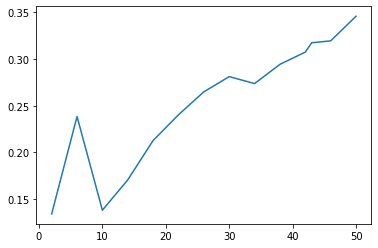

In [15]:
x = []
for i in range(2, 51, 4):
    x.append(i)
    if i == 42:
        x.append(43)
plt.plot(x, errors)
plt.show() 

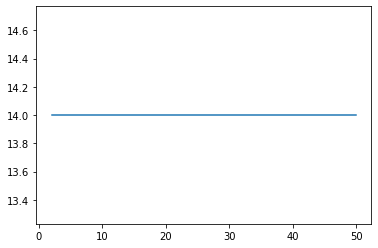

In [16]:
plt.plot(x, mscis)
plt.show()

In [17]:
import pickle
import warnings

# Filter out specific warning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
# Suppress all warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Automatically generate configurations
configurations = [
    {
        "id": i,
        "train_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/trainset_{i}.pkl",
        "clean_val_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/cl-viliset_{i}.pkl",
        "back_val_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/bd-valiset_{i}.pkl",
        "test_path": f"/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/backdoored-test/300/{i}"
    }
    for i in range(2, 3)
]
# Transforming the Data ToTensor and Normalize it 

data_transforms = T.Compose([T.ToTensor(),T.Resize((224,224),antialias=True),T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
data_transforms_train  = T.Compose([T.ToTensor(),T.Resize((224,224),antialias=True)])
normalize=T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
batch_size = 32
entropy_trojan=[]
entropy_benigh=[]

for config in configurations:
    print(f"Training for configuration ID: {config['id']}")

    # Initialize the model
    num_classes = 43  # The number of output classes in your trained model
    model = alexnet(weights=None, num_classes=43).to(device)
    model_path=f"models/50-epoch_model/alexnet_case_{config['id']}.pt"
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)

 
    # Training Dataset
    train_dataset_path = config["train_path"]
    # train_dataset = TSignsDataset(train_dataset_path, transform=data_transforms_train)


#     #clean validation images organized in directory for each class
#     clean_validation_path = config["clean_val_path"]
#     clean_validation_dataset = TSignsDataset(clean_validation_path,transform=data_transforms)

#     backdoored_validation_path = config["back_val_path"]
#     backdoored_validation_dataset = TSignsDataset(backdoored_validation_path,transform=data_transforms)

    #splitting the data into training and validation 
#     L1 = len(train_dataset)
#     L3 = len(clean_validation_dataset)
#     L2 = len(backdoored_validation_dataset)
#     print(f"Total length of Dataset Imported: ",L1, L2, L3)


    # Loading the data into DataLoader
    with open(train_dataset_path, "rb") as pickle_file:
        train_dataset = pickle.load(pickle_file)
    pickle_file.close()
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
#     clean_val_loader = DataLoader(dataset=clean_validation_dataset, batch_size=1, shuffle=False)
#     bck_val_loader = DataLoader(dataset=backdoored_validation_dataset, batch_size=1, shuffle=False)

    ##CLEANING THE TRAINING DATASET################################
    # Assuming suspicious_indices is a list of indices for suspicious images
    # msci=most_suspicious_class_info
    errors = []
    mscis = []
    inds = []
    for i in range(2, 51, 4):
        msci, error, suspicious_indices = cleanser(train_loader, model, num_classes, device, verify_suspicious_indices, i)
        errors.append(error)
        mscis.append(msci)
        inds.append(suspicious_indices)
        
        if i == 42:
            msci, error, suspicious_indices = cleanser(train_loader, model, num_classes, device, verify_suspicious_indices, 43)
            errors.append(error)
            mscis.append(msci)
            inds.append(suspicious_indices)

    # x = [i for i in range(2, 51, 4)]
    # plt.plot(x, errors)
    # plt.show()

print("Training completed for all configurations!")




Training for configuration ID: 2


 11%|█         | 90/801 [00:02<00:15, 44.60it/s]

100%|██████████| 801/801 [00:18<00:00, 44.44it/s]


Training completed for all configurations!


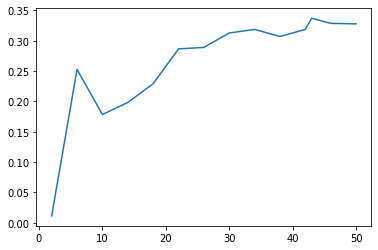

In [20]:
x = []
for i in range(2, 51, 4):
    x.append(i)
    if i == 42:
        x.append(43)
plt.plot(x, errors)
plt.show()

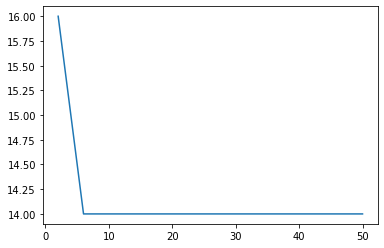

In [19]:
plt.plot(x, mscis)
plt.show()

In [14]:
import pickle
import warnings

# Filter out specific warning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
# Suppress all warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Automatically generate configurations
configurations = [
    {
        "id": i,
        "train_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/trainset_{i}.pkl",
        "clean_val_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/cl-viliset_{i}.pkl",
        "back_val_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/bd-valiset_{i}.pkl",
        "test_path": f"/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/backdoored-test/300/{i}"
    }
    for i in range(3, 4)
]
# Transforming the Data ToTensor and Normalize it 

data_transforms = T.Compose([T.ToTensor(),T.Resize((224,224),antialias=True),T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
data_transforms_train  = T.Compose([T.ToTensor(),T.Resize((224,224),antialias=True)])
normalize=T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
batch_size = 32
entropy_trojan=[]
entropy_benigh=[]

for config in configurations:
    print(f"Training for configuration ID: {config['id']}")

    # Initialize the model
    num_classes = 43  # The number of output classes in your trained model
    model = alexnet(weights=None, num_classes=43).to(device)
    model_path=f"models/50-epoch_model/alexnet_case_{config['id']}.pt"
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)

 
    # Training Dataset
    train_dataset_path = config["train_path"]
    # train_dataset = TSignsDataset(train_dataset_path, transform=data_transforms_train)


#     #clean validation images organized in directory for each class
#     clean_validation_path = config["clean_val_path"]
#     clean_validation_dataset = TSignsDataset(clean_validation_path,transform=data_transforms)

#     backdoored_validation_path = config["back_val_path"]
#     backdoored_validation_dataset = TSignsDataset(backdoored_validation_path,transform=data_transforms)

    #splitting the data into training and validation 
#     L1 = len(train_dataset)
#     L3 = len(clean_validation_dataset)
#     L2 = len(backdoored_validation_dataset)
#     print(f"Total length of Dataset Imported: ",L1, L2, L3)


    # Loading the data into DataLoader
    with open(train_dataset_path, "rb") as pickle_file:
        train_dataset = pickle.load(pickle_file)
    pickle_file.close()
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
#     clean_val_loader = DataLoader(dataset=clean_validation_dataset, batch_size=1, shuffle=False)
#     bck_val_loader = DataLoader(dataset=backdoored_validation_dataset, batch_size=1, shuffle=False)

    ##CLEANING THE TRAINING DATASET################################
    # Assuming suspicious_indices is a list of indices for suspicious images
    # msci=most_suspicious_class_info
    errors = []
    mscis = []
    inds = []
    for i in range(2, 51, 4):
        msci, error, suspicious_indices = cleanser(train_loader, model, num_classes, device, verify_suspicious_indices, i)
        errors.append(error)
        mscis.append(msci)
        inds.append(suspicious_indices)
        
        if i == 42:
            msci, error, suspicious_indices = cleanser(train_loader, model, num_classes, device, verify_suspicious_indices, 43)
            errors.append(error)
            mscis.append(msci)
            inds.append(suspicious_indices)

    # x = [i for i in range(2, 51, 4)]
    # plt.plot(x, errors)
    # plt.show()

print("Training completed for all configurations!")




Training for configuration ID: 3


100%|██████████| 801/801 [00:17<00:00, 44.87it/s]


Training completed for all configurations!


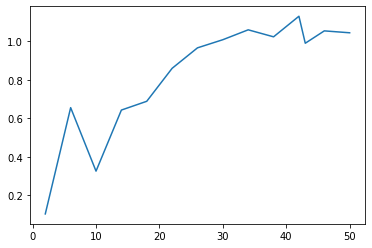

In [15]:
x = []
for i in range(2, 51, 4):
    x.append(i)
    if i == 42:
        x.append(43)
plt.plot(x, errors)
plt.show()

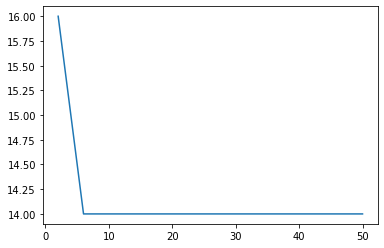

In [16]:
plt.plot(x, mscis)
plt.show()

In [22]:
import pickle
import warnings

# Filter out specific warning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
# Suppress all warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Automatically generate configurations
configurations = [
    {
        "id": i,
        "train_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/trainset_{i}.pkl",
        "clean_val_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/cl-viliset_{i}.pkl",
        "back_val_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/bd-valiset_{i}.pkl",
        "test_path": f"/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/backdoored-test/300/{i}"
    }
    for i in range(6, 7)
]
# Transforming the Data ToTensor and Normalize it 

data_transforms = T.Compose([T.ToTensor(),T.Resize((224,224),antialias=True),T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
data_transforms_train  = T.Compose([T.ToTensor(),T.Resize((224,224),antialias=True)])
normalize=T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
batch_size = 32
entropy_trojan=[]
entropy_benigh=[]

for config in configurations:
    print(f"Training for configuration ID: {config['id']}")

    # Initialize the model
    num_classes = 43  # The number of output classes in your trained model
    model = alexnet(weights=None, num_classes=43).to(device)
    model_path=f"models/50-epoch_model/alexnet_case_{config['id']}.pt"
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)

 
    # Training Dataset
    train_dataset_path = config["train_path"]
    # train_dataset = TSignsDataset(train_dataset_path, transform=data_transforms_train)


#     #clean validation images organized in directory for each class
#     clean_validation_path = config["clean_val_path"]
#     clean_validation_dataset = TSignsDataset(clean_validation_path,transform=data_transforms)

#     backdoored_validation_path = config["back_val_path"]
#     backdoored_validation_dataset = TSignsDataset(backdoored_validation_path,transform=data_transforms)

    #splitting the data into training and validation 
#     L1 = len(train_dataset)
#     L3 = len(clean_validation_dataset)
#     L2 = len(backdoored_validation_dataset)
#     print(f"Total length of Dataset Imported: ",L1, L2, L3)


    # Loading the data into DataLoader
    with open(train_dataset_path, "rb") as pickle_file:
        train_dataset = pickle.load(pickle_file)
    pickle_file.close()
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
#     clean_val_loader = DataLoader(dataset=clean_validation_dataset, batch_size=1, shuffle=False)
#     bck_val_loader = DataLoader(dataset=backdoored_validation_dataset, batch_size=1, shuffle=False)

    ##CLEANING THE TRAINING DATASET################################
    # Assuming suspicious_indices is a list of indices for suspicious images
    # msci=most_suspicious_class_info
    errors = []
    mscis = []
    inds = []
    for i in range(2, 51, 4):
        msci, error, suspicious_indices = cleanser(train_loader, model, num_classes, device, verify_suspicious_indices, i)
        errors.append(error)
        mscis.append(msci)
        inds.append(suspicious_indices)
        
        if i == 42:
            msci, error, suspicious_indices = cleanser(train_loader, model, num_classes, device, verify_suspicious_indices, 43)
            errors.append(error)
            mscis.append(msci)
            inds.append(suspicious_indices)

    # x = [i for i in range(2, 51, 4)]
    # plt.plot(x, errors)
    # plt.show()

print("Training completed for all configurations!")




Training for configuration ID: 6


100%|██████████| 801/801 [00:17<00:00, 45.12it/s]


Training completed for all configurations!


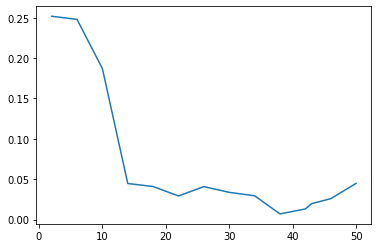

In [23]:
x = []
for i in range(2, 51, 4):
    x.append(i)
    if i == 42:
        x.append(43)
plt.plot(x, errors)
plt.show()

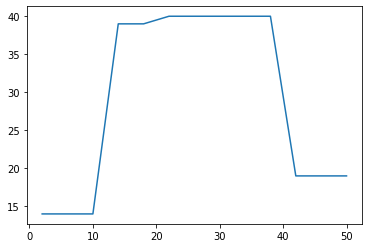

In [24]:
plt.plot(x, mscis)
plt.show()

In [11]:
import pickle
import warnings

# Filter out specific warning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
# Suppress all warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Automatically generate configurations
configurations = [
    {
        "id": i,
        "train_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/trainset_{i}.pkl",
        "clean_val_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/cl-viliset_{i}.pkl",
        "back_val_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/bd-valiset_{i}.pkl",
        "test_path": f"/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/backdoored-test/300/{i}"
    }
    for i in range(7, 8)
]
# Transforming the Data ToTensor and Normalize it 

data_transforms = T.Compose([T.ToTensor(),T.Resize((224,224),antialias=True),T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
data_transforms_train  = T.Compose([T.ToTensor(),T.Resize((224,224),antialias=True)])
normalize=T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
batch_size = 32
entropy_trojan=[]
entropy_benigh=[]

for config in configurations:
    print(f"Training for configuration ID: {config['id']}")

    # Initialize the model
    num_classes = 43  # The number of output classes in your trained model
    model = alexnet(weights=None, num_classes=43).to(device)
    model_path=f"models/50-epoch_model/alexnet_case_{config['id']}.pt"
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)

 
    # Training Dataset
    train_dataset_path = config["train_path"]
    # train_dataset = TSignsDataset(train_dataset_path, transform=data_transforms_train)


#     #clean validation images organized in directory for each class
#     clean_validation_path = config["clean_val_path"]
#     clean_validation_dataset = TSignsDataset(clean_validation_path,transform=data_transforms)

#     backdoored_validation_path = config["back_val_path"]
#     backdoored_validation_dataset = TSignsDataset(backdoored_validation_path,transform=data_transforms)

    #splitting the data into training and validation 
#     L1 = len(train_dataset)
#     L3 = len(clean_validation_dataset)
#     L2 = len(backdoored_validation_dataset)
#     print(f"Total length of Dataset Imported: ",L1, L2, L3)


    # Loading the data into DataLoader
    with open(train_dataset_path, "rb") as pickle_file:
        train_dataset = pickle.load(pickle_file)
    pickle_file.close()
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
#     clean_val_loader = DataLoader(dataset=clean_validation_dataset, batch_size=1, shuffle=False)
#     bck_val_loader = DataLoader(dataset=backdoored_validation_dataset, batch_size=1, shuffle=False)

    ##CLEANING THE TRAINING DATASET################################
    # Assuming suspicious_indices is a list of indices for suspicious images
    # msci=most_suspicious_class_info
    errors = []
    mscis = []
    inds = []
    for i in range(2, 51, 4):
        msci, error, suspicious_indices = cleanser(train_loader, model, num_classes, device, verify_suspicious_indices, i)
        errors.append(error)
        mscis.append(msci)
        inds.append(suspicious_indices)
        
        if i == 42:
            msci, error, suspicious_indices = cleanser(train_loader, model, num_classes, device, verify_suspicious_indices, 43)
            errors.append(error)
            mscis.append(msci)
            inds.append(suspicious_indices)

    # x = [i for i in range(2, 51, 4)]
    # plt.plot(x, errors)
    # plt.show()

print("Training completed for all configurations!")




Training for configuration ID: 7


100%|██████████| 801/801 [00:17<00:00, 45.45it/s]


Training completed for all configurations!


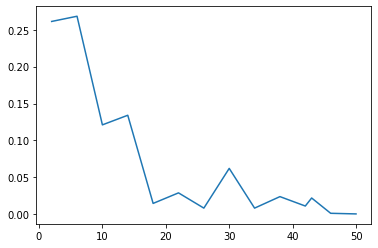

In [12]:
x = []
for i in range(2, 51, 4):
    x.append(i)
    if i == 42:
        x.append(43)
plt.plot(x, errors)
plt.show()

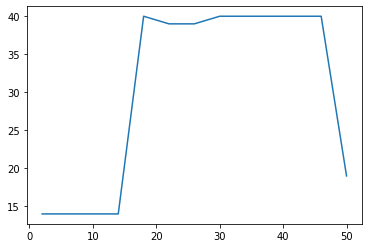

In [13]:
plt.plot(x, mscis)
plt.show()

Unified method

In [15]:
import pickle
import warnings

# Filter out specific warning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
# Suppress all warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Automatically generate configurations
configurations = [
    {
        "id": i,
        "train_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/trainset_{i}.pkl",
        "clean_val_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/cl-viliset_{i}.pkl",
        "back_val_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/bd-valiset_{i}.pkl",
        "test_path": f"/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/backdoored-test/300/{i}"
    }
    for i in range(1, 25)
]
# Transforming the Data ToTensor and Normalize it 

data_transforms = T.Compose([T.ToTensor(),T.Resize((224,224),antialias=True),T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
data_transforms_train  = T.Compose([T.ToTensor(),T.Resize((224,224),antialias=True)])
normalize=T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
batch_size = 32
entropy_trojan=[]
entropy_benigh=[]

for config in configurations:
    print(f"Training for configuration ID: {config['id']}")

    # Initialize the model
    num_classes = 43  # The number of output classes in your trained model
    model = alexnet(weights=None, num_classes=43).to(device)
    model_path=f"models/50-epoch_model/alexnet_case_{config['id']}.pt"
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)

 
    # Training Dataset
    train_dataset_path = config["train_path"]
    # train_dataset = TSignsDataset(train_dataset_path, transform=data_transforms_train)


#     #clean validation images organized in directory for each class
#     clean_validation_path = config["clean_val_path"]
#     clean_validation_dataset = TSignsDataset(clean_validation_path,transform=data_transforms)

#     backdoored_validation_path = config["back_val_path"]
#     backdoored_validation_dataset = TSignsDataset(backdoored_validation_path,transform=data_transforms)

    #splitting the data into training and validation 
#     L1 = len(train_dataset)
#     L3 = len(clean_validation_dataset)
#     L2 = len(backdoored_validation_dataset)
#     print(f"Total length of Dataset Imported: ",L1, L2, L3)


    # Loading the data into DataLoader
    with open(train_dataset_path, "rb") as pickle_file:
        train_dataset = pickle.load(pickle_file)
    pickle_file.close()
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
#     clean_val_loader = DataLoader(dataset=clean_validation_dataset, batch_size=1, shuffle=False)
#     bck_val_loader = DataLoader(dataset=backdoored_validation_dataset, batch_size=1, shuffle=False)

    ##CLEANING THE TRAINING DATASET################################
    # Assuming suspicious_indices is a list of indices for suspicious images
    # msci=most_suspicious_class_info
    msci_2,error_2,suspicious_indices = cleanser(train_loader, model, num_classes, device,verify_suspicious_indices)
    msci_43,error_43,suspicious_indices = cleanser(train_loader, model, num_classes, device,verify_suspicious_indices,43)
    if error_2 > error_43:
        suspicious_class = msci_2
    else:
        suspicious_class = msci_43
    
    print("Most suspicious class: ", suspicious_class)
    # print("Len of suspicious indices: ",len(suspicious_indices))

    # verify_suspicious_indices(train_loader.dataset, suspicious_indices, most_suspicious_class)
    # Assuming suspicious_indices contains the indices to be excluded
#     clean_train_set = TSignsDataset(root_dir=train_dataset_path, transform=data_transforms, exclude_indices=suspicious_indices)

#     clean_train_loader = DataLoader(dataset=clean_train_set, batch_size=batch_size, shuffle=True)


#     dataloaders = {'training':clean_train_loader,"clean": clean_val_loader, "backdoor": bck_val_loader}
#     dataset_sizes = {'training':len(clean_train_loader.dataset), "clean": len(clean_val_loader), "backdoor": len(bck_val_loader)}
#     print(dataset_sizes)


#     #initialize new model to train from scratch with only clean dataset 
#     new_model = alexnet(weights=None, num_classes=43).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(new_model.parameters(), lr=0.0001)
#     num_epochs = 50
#     out_path = f"alexnet_activation_epochs50_backdoored_config{config['id']}.pt"


#     # Store metrics
#     train_loss, clean_val_loss,backdoored_val_loss = [], [], []
#     train_acc, clen_val_acc,val_backdoored_acc = [], [], []
#     # Train the model
#     train_loss, clean_val_loss,backdoored_val_loss ,train_acc, clean_val_acc, val_backdoored_acc,best_acc = Train(new_model, criterion, optimizer, num_epochs, batch_size, dataloaders, out_path,device)
#     plot_accuracy(train_loss, clean_val_loss,backdoored_val_loss ,train_acc, clean_val_acc,val_backdoored_acc)
#     print('Best validation Accuracy:', best_acc)
    
# #     #Test accuracy on Clean dataset
#     print("Accuracy on Test Clean dataset ")
#     test_dataset_clean = 'gtsrb-german-traffic-sign/Test'
#     predict_on_clean_Dataset(test_dataset_clean, out_path, num_images_to_test=2000, device=device)
    
#     #Test accuracy on backdoored dataset
#     print("Accuracy on Test Backdoored dataset")
#     test_dataset_path_backdoored=config["test_path"]
#     predict_on_backdoored_directory(test_dataset_path_backdoored, out_path, num_images_to_test=400, device=device)
# 

print("Training completed for all configurations!")




Training for configuration ID: 1


100%|██████████| 801/801 [00:17<00:00, 45.43it/s]


Most suspicious class:  14
Training for configuration ID: 2


100%|██████████| 801/801 [00:17<00:00, 45.47it/s]


Most suspicious class:  14
Training for configuration ID: 3


100%|██████████| 801/801 [00:17<00:00, 44.73it/s]


Most suspicious class:  14
Training for configuration ID: 4


100%|██████████| 801/801 [00:17<00:00, 45.50it/s]


Most suspicious class:  14
Training for configuration ID: 5


100%|██████████| 801/801 [00:17<00:00, 44.58it/s]


Most suspicious class:  14
Training for configuration ID: 6


100%|██████████| 801/801 [00:17<00:00, 45.61it/s]


Most suspicious class:  14
Training for configuration ID: 7


100%|██████████| 801/801 [00:17<00:00, 45.43it/s]


Most suspicious class:  14
Training for configuration ID: 8


100%|██████████| 801/801 [00:18<00:00, 44.47it/s]


Most suspicious class:  14
Training for configuration ID: 9


100%|██████████| 801/801 [00:17<00:00, 44.82it/s]


Most suspicious class:  14
Training for configuration ID: 10


100%|██████████| 801/801 [00:17<00:00, 45.42it/s]


Most suspicious class:  14
Training for configuration ID: 11


100%|██████████| 801/801 [00:17<00:00, 45.03it/s]


Most suspicious class:  14
Training for configuration ID: 12


100%|██████████| 801/801 [00:17<00:00, 45.53it/s]


Most suspicious class:  14
Training for configuration ID: 13


100%|██████████| 801/801 [00:17<00:00, 45.76it/s]


Most suspicious class:  14
Training for configuration ID: 14


100%|██████████| 801/801 [00:17<00:00, 44.92it/s]


Most suspicious class:  14
Training for configuration ID: 15


100%|██████████| 801/801 [00:18<00:00, 44.32it/s]


Most suspicious class:  14
Training for configuration ID: 16


100%|██████████| 801/801 [00:17<00:00, 44.60it/s]


Most suspicious class:  14
Training for configuration ID: 17


100%|██████████| 801/801 [00:17<00:00, 45.23it/s]


Most suspicious class:  14
Training for configuration ID: 18


100%|██████████| 801/801 [00:17<00:00, 45.49it/s]


Most suspicious class:  14
Training for configuration ID: 19


100%|██████████| 801/801 [00:17<00:00, 44.92it/s]


Most suspicious class:  14
Training for configuration ID: 20


100%|██████████| 801/801 [00:17<00:00, 45.42it/s]


Most suspicious class:  14
Training for configuration ID: 21


100%|██████████| 801/801 [00:17<00:00, 44.99it/s]


Most suspicious class:  14
Training for configuration ID: 22


100%|██████████| 801/801 [00:17<00:00, 44.83it/s]


Most suspicious class:  14
Training for configuration ID: 23


100%|██████████| 801/801 [00:17<00:00, 45.57it/s]


Most suspicious class:  14
Training for configuration ID: 24


100%|██████████| 801/801 [00:17<00:00, 45.16it/s]


Most suspicious class:  14
Training completed for all configurations!


In [12]:
import pickle
import warnings

# Filter out specific warning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
# Suppress all warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Automatically generate configurations
configurations = [
    {
        "id": i,
        "train_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/cifar/trainset_{i}.pkl",
        "clean_val_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/cifar/cl-viliset_{i}.pkl",
        "back_val_path": f"/home/cc7486/Desktop/Research/Jupyter/pickle/cifar/bd-valiset_{i}.pkl",
        "test_path": f"/home/cc7486/Desktop/Research/cifar10/cifar10/test/{i}"
    }
    for i in range(1, 25)
]
# Transforming the Data ToTensor and Normalize it 

data_transforms = T.Compose([T.ToTensor(),T.Resize((224,224),antialias=True),T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
data_transforms_train  = T.Compose([T.ToTensor(),T.Resize((224,224),antialias=True)])
normalize=T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
batch_size = 32
entropy_trojan=[]
entropy_benigh=[]

for config in configurations:
    print(f"Training for configuration ID: {config['id']}")

    # Initialize the model
    num_classes = 10  # The number of output classes in your trained model
    model = alexnet(weights=None, num_classes=10).to(device)
    model_path=f"models/cifar_models/alexnet_case_{config['id']}.pt"
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)

 
    # Training Dataset
    train_dataset_path = config["train_path"]
    # train_dataset = TSignsDataset(train_dataset_path, transform=data_transforms_train)


#     #clean validation images organized in directory for each class
#     clean_validation_path = config["clean_val_path"]
#     clean_validation_dataset = TSignsDataset(clean_validation_path,transform=data_transforms)

#     backdoored_validation_path = config["back_val_path"]
#     backdoored_validation_dataset = TSignsDataset(backdoored_validation_path,transform=data_transforms)

    #splitting the data into training and validation 
#     L1 = len(train_dataset)
#     L3 = len(clean_validation_dataset)
#     L2 = len(backdoored_validation_dataset)
#     print(f"Total length of Dataset Imported: ",L1, L2, L3)


    # Loading the data into DataLoader
    with open(train_dataset_path, "rb") as pickle_file:
        train_dataset = pickle.load(pickle_file)
    pickle_file.close()
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
#     clean_val_loader = DataLoader(dataset=clean_validation_dataset, batch_size=1, shuffle=False)
#     bck_val_loader = DataLoader(dataset=backdoored_validation_dataset, batch_size=1, shuffle=False)

    ##CLEANING THE TRAINING DATASET################################
    # Assuming suspicious_indices is a list of indices for suspicious images
    # msci=most_suspicious_class_info
    msci_2,error_2,suspicious_indices = cleanser(train_loader, model, num_classes, device,verify_suspicious_indices)
    msci_43,error_43,suspicious_indices = cleanser(train_loader, model, num_classes, device,verify_suspicious_indices,num_classes)
    if error_2 > error_43:
        suspicious_class = msci_2
    else:
        suspicious_class = msci_43
    
    print("Most suspicious class: ", suspicious_class)
    # print("Len of suspicious indices: ",len(suspicious_indices))

    # verify_suspicious_indices(train_loader.dataset, suspicious_indices, most_suspicious_class)
    # Assuming suspicious_indices contains the indices to be excluded
#     clean_train_set = TSignsDataset(root_dir=train_dataset_path, transform=data_transforms, exclude_indices=suspicious_indices)

#     clean_train_loader = DataLoader(dataset=clean_train_set, batch_size=batch_size, shuffle=True)


#     dataloaders = {'training':clean_train_loader,"clean": clean_val_loader, "backdoor": bck_val_loader}
#     dataset_sizes = {'training':len(clean_train_loader.dataset), "clean": len(clean_val_loader), "backdoor": len(bck_val_loader)}
#     print(dataset_sizes)


#     #initialize new model to train from scratch with only clean dataset 
#     new_model = alexnet(weights=None, num_classes=43).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(new_model.parameters(), lr=0.0001)
#     num_epochs = 50
#     out_path = f"alexnet_activation_epochs50_backdoored_config{config['id']}.pt"


#     # Store metrics
#     train_loss, clean_val_loss,backdoored_val_loss = [], [], []
#     train_acc, clen_val_acc,val_backdoored_acc = [], [], []
#     # Train the model
#     train_loss, clean_val_loss,backdoored_val_loss ,train_acc, clean_val_acc, val_backdoored_acc,best_acc = Train(new_model, criterion, optimizer, num_epochs, batch_size, dataloaders, out_path,device)
#     plot_accuracy(train_loss, clean_val_loss,backdoored_val_loss ,train_acc, clean_val_acc,val_backdoored_acc)
#     print('Best validation Accuracy:', best_acc)
    
# #     #Test accuracy on Clean dataset
#     print("Accuracy on Test Clean dataset ")
#     test_dataset_clean = 'gtsrb-german-traffic-sign/Test'
#     predict_on_clean_Dataset(test_dataset_clean, out_path, num_images_to_test=2000, device=device)
    
#     #Test accuracy on backdoored dataset
#     print("Accuracy on Test Backdoored dataset")
#     test_dataset_path_backdoored=config["test_path"]
#     predict_on_backdoored_directory(test_dataset_path_backdoored, out_path, num_images_to_test=400, device=device)
# 

print("Training completed for all configurations!")

Training for configuration ID: 1


100%|██████████| 1010/1010 [00:20<00:00, 48.50it/s]


Most suspicious class:  7
Training for configuration ID: 2


100%|██████████| 1010/1010 [00:20<00:00, 49.08it/s]


Most suspicious class:  7
Training for configuration ID: 3


100%|██████████| 1010/1010 [00:20<00:00, 48.15it/s]


Most suspicious class:  7
Training for configuration ID: 4


100%|██████████| 1010/1010 [00:20<00:00, 48.98it/s]


Most suspicious class:  7
Training for configuration ID: 5


100%|██████████| 1010/1010 [00:20<00:00, 48.46it/s]


Most suspicious class:  7
Training for configuration ID: 6


100%|██████████| 1010/1010 [00:20<00:00, 49.25it/s]


Most suspicious class:  7
Training for configuration ID: 7


100%|██████████| 1010/1010 [00:20<00:00, 49.11it/s]


Most suspicious class:  7
Training for configuration ID: 8


100%|██████████| 1010/1010 [00:20<00:00, 48.78it/s]


Most suspicious class:  7
Training for configuration ID: 9


100%|██████████| 1010/1010 [00:21<00:00, 47.47it/s]


Most suspicious class:  7
Training for configuration ID: 10


100%|██████████| 1010/1010 [00:20<00:00, 49.15it/s]


Most suspicious class:  7
Training for configuration ID: 11


100%|██████████| 1010/1010 [00:20<00:00, 48.50it/s]


Most suspicious class:  7
Training for configuration ID: 12


100%|██████████| 1010/1010 [00:20<00:00, 48.10it/s]


Most suspicious class:  7
Training for configuration ID: 13


100%|██████████| 1010/1010 [00:21<00:00, 47.95it/s]


Most suspicious class:  7
Training for configuration ID: 14


100%|██████████| 1010/1010 [00:20<00:00, 48.22it/s]


Most suspicious class:  7
Training for configuration ID: 15


100%|██████████| 1010/1010 [00:21<00:00, 47.89it/s]


Most suspicious class:  7
Training for configuration ID: 16


100%|██████████| 1010/1010 [00:21<00:00, 47.66it/s]


Most suspicious class:  7
Training for configuration ID: 17


100%|██████████| 1010/1010 [00:21<00:00, 47.70it/s]


Most suspicious class:  7
Training for configuration ID: 18


100%|██████████| 1010/1010 [00:20<00:00, 48.22it/s]


Most suspicious class:  7
Training for configuration ID: 19


100%|██████████| 1010/1010 [00:21<00:00, 47.61it/s]


Most suspicious class:  7
Training for configuration ID: 20


100%|██████████| 1010/1010 [00:21<00:00, 47.95it/s]


Most suspicious class:  7
Training for configuration ID: 21


100%|██████████| 1010/1010 [00:21<00:00, 47.59it/s]


Most suspicious class:  7
Training for configuration ID: 22


100%|██████████| 1010/1010 [00:21<00:00, 47.67it/s]


Most suspicious class:  7
Training for configuration ID: 23


100%|██████████| 1010/1010 [00:21<00:00, 47.52it/s]


Most suspicious class:  7
Training for configuration ID: 24


100%|██████████| 1010/1010 [00:21<00:00, 47.67it/s]


Most suspicious class:  7
Training completed for all configurations!
